Imports

In [2]:
# !pip install scipy==1.6.0
# !pip install matplotlib==3.1.0

In [48]:
import os, json, random
random.seed(1)
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import Markdown, display, Image
from tqdm import tqdm
from collections import OrderedDict
import matplotlib.pyplot as plt
%matplotlib inline

In [49]:
# AIF360
import aif360
from aif360.datasets import CompasDataset
from aif360.sklearn.datasets import fetch_compas
# fairness metrics
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric, DatasetMetric
from aif360.metrics.common_utils import compute_metrics
from aif360.metrics.utils import compute_num_instances
# data preprocessing
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions import load_preproc_data_compas
# explainers
from aif360.explainers import MetricTextExplainer
# bias mitigation techniques
from aif360.algorithms.preprocessing import Reweighing
from aif360.algorithms.inprocessing import AdversarialDebiasing, PrejudiceRemover, GerryFairClassifier
from aif360.sklearn.inprocessing import AdversarialDebiasing as SKLearnAdversarialDebiasing
from aif360.algorithms.inprocessing.gerryfair.clean import array_to_tuple
from aif360.algorithms.inprocessing.gerryfair.auditor import Auditor
from aif360.algorithms.postprocessing import CalibratedEqOddsPostprocessing, RejectOptionClassification
from aif360.sklearn.utils import check_inputs, check_groups

In [50]:
# TensorFlow
import tensorflow
import tensorflow.compat.v1 as tf
tf.compat.v1.disable_eager_execution()

In [51]:
import sklearn
# scalers
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
# classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm, tree, linear_model
# metrics
from sklearn.metrics import accuracy_score, roc_curve, classification_report, confusion_matrix
# kernels
from sklearn.kernel_ridge import KernelRidge

from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.datasets import make_blobs
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold
from sklearn.inspection import permutation_importance

Helper Functions

In [52]:
FILES = '/Users/megantennies/FYP/saved data'

In [53]:
def save_to_json(filename, data):
    with open(os.path.join(FILES, filename), 'w') as write:
        json.dump(data, write)

In [54]:
def json_to_df(filename):
    with open(os.path.join(FILES, filename), 'r') as load:
        data = json.load(load)
        df = pd.read_json(data, orient = 'split')
    return df

In [55]:
def df_to_json(filename, df):
    df.to_json(os.path.join(FILES, filename), orient = 'split', 
    compression = 'infer', index = True)

Data

In [57]:
privileged_groups = [{'race': 1}]
unprivileged_groups = [{'race': 0}]
original_dataset = load_preproc_data_compas(['race'])

In [58]:
default_mappings = {'label_maps': [{1.0: 'Recid', 0.0: 'Non-Recid'}], 
    'protected_attribute_maps': [{1.0: 'Male', 0.0: 'Female'}, 
    {1.0: 'White', 0.0: 'Non-White'}]}
metrics = ['Statistical parity difference', 'Average odds difference', 
    'Equal opportunity difference']

In [59]:
original_train, original_val_test = original_dataset.split([0.7], shuffle = True)
original_val, original_test = original_val_test.split([0.5], shuffle = True)

In [60]:
def describe(train = None, val = None, test = None):
    if train is not None:
        display(Markdown('#### Training dataset shape'))
        print(train.features.shape)
    if val is not None:
        display(Markdown('#### Validation dataset shape'))
        print(val.features.shape)
    display(Markdown('#### Test dataset shape'))
    print(test.features.shape)
    display(Markdown('#### Favorable and unfavorable labels'))
    print(test.favorable_label, test.unfavorable_label)
    display(Markdown('#### Protected attribute names'))
    print(test.protected_attribute_names)
    display(Markdown('#### Privileged and unprivileged protected attribute values'))
    print(test.privileged_protected_attributes, test.unprivileged_protected_attributes)
    display(Markdown("#### Dataset feature names"))
    print(train.feature_names)

In [61]:
describe(original_train, original_val, original_test)

#### Training dataset shape

(3694, 10)


#### Validation dataset shape

(792, 10)


#### Test dataset shape

(792, 10)


#### Favorable and unfavorable labels

0.0 1.0


#### Protected attribute names

['race']


#### Privileged and unprivileged protected attribute values

[array([1.])] [array([0.])]


#### Dataset feature names

['sex', 'race', 'age_cat=25 to 45', 'age_cat=Greater than 45', 'age_cat=Less than 25', 'priors_count=0', 'priors_count=1 to 3', 'priors_count=More than 3', 'c_charge_degree=F', 'c_charge_degree=M']


In [62]:
original_metric = BinaryLabelDatasetMetric(original_train, 
    unprivileged_groups = unprivileged_groups, 
    privileged_groups = privileged_groups)

In [63]:
original_explainer = MetricTextExplainer(original_metric)
display(Markdown('#### Original COMPAS training data'))

original_train_metric = BinaryLabelDatasetMetric(original_train, 
    unprivileged_groups = unprivileged_groups, privileged_groups = privileged_groups)
print('Training data: Difference in mean outcomes between unprivileged and privileged groups = %f' % original_train_metric.mean_difference())

original_val_metric = BinaryLabelDatasetMetric(original_val, 
    unprivileged_groups = unprivileged_groups, privileged_groups = privileged_groups)
print('Validation data: Difference in mean outcomes between unprivileged and privileged groups = %f' % original_val_metric.mean_difference())

original_test_metric = BinaryLabelDatasetMetric(original_test, 
    unprivileged_groups = unprivileged_groups, privileged_groups = privileged_groups)
print('Testing data: Difference in mean outcomes between unprivileged and privileged groups = %f' % original_test_metric.mean_difference())

#### Original COMPAS training data

Training data: Difference in mean outcomes between unprivileged and privileged groups = -0.133986
Validation data: Difference in mean outcomes between unprivileged and privileged groups = -0.137431
Testing data: Difference in mean outcomes between unprivileged and privileged groups = -0.117521


LR

In [64]:
original_scaler = StandardScaler()
X_train = original_scaler.fit_transform(original_train.features)
y_train = original_train.labels.ravel()
w_train = original_train.instance_weights.ravel()

In [65]:
lr = LogisticRegression()
lr.fit(X_train, y_train, sample_weight = original_train.instance_weights)
y_train_preds = lr.predict(X_train)

In [66]:
pos_ind = np.where(lr.classes_ == original_train.favorable_label)[0][0]

In [67]:
original_train_preds = original_train.copy()
original_train_preds.labels = y_train_preds

original_val_preds = original_val.copy(deepcopy = True)
X_val = original_scaler.transform(original_val_preds.features)
y_val = original_val_preds.labels
original_val_preds.scores = lr.predict_proba(X_val)[:, pos_ind].reshape(-1, 1)

original_test_preds = original_test.copy(deepcopy = True)
X_test = original_scaler.transform(original_test_preds.features)
y_test = original_test_preds.labels
original_test_preds.scores = lr.predict_proba(X_test)[:, pos_ind].reshape(-1, 1)

In [68]:
num_thresh = 100
bal_arr = np.zeros(num_thresh)
class_thresh_arr = np.linspace(0.01, 0.99, num_thresh)

for idx, class_thresh in enumerate(class_thresh_arr):
    fav_inds = original_val_preds.scores > class_thresh
    original_val_preds.labels[fav_inds] = original_val_preds.favorable_label
    original_val_preds.labels[~fav_inds] = original_val_preds.unfavorable_label

    original_val_metric = ClassificationMetric(original_val, 
        original_val_preds, unprivileged_groups = unprivileged_groups, 
        privileged_groups = privileged_groups)

    bal_arr[idx] = 0.5 * (original_val_metric.true_positive_rate() 
        + original_val_metric.true_negative_rate())

In [69]:
best_ind = np.where(bal_arr == np.max(bal_arr))[0][0]
best_class_thresh = class_thresh_arr[best_ind]

display(Markdown('#### Original COMPAS data'))
print('Best balanced accuracy (no transforming): %.4f' % np.max(bal_arr))
print('Optimal classification threshold (no transforming): %.4f' % best_class_thresh)

#### Original COMPAS data

Best balanced accuracy (no transforming): 0.6628
Optimal classification threshold (no transforming): 0.5742


In [70]:
bal_acc_arr = []
disp_imp_arr = []
avg_odds_diff_arr = []
eq_opp_diff_arr = []
outcome_unfair_arr = []
acc_equal_arr = []

In [71]:
display(Markdown('#### Predictions from the original testing data'))
print('Classification threshold used: %.4f' % best_class_thresh)

for thresh in tqdm(class_thresh_arr):
    if thresh == best_class_thresh:
        disp = True
    else:
        disp = False
    fav_inds = original_test_preds.scores > thresh
    original_test_preds.labels[fav_inds] = original_test_preds.favorable_label
    original_test_preds.labels[~fav_inds] = original_test_preds.unfavorable_label
    
    metric_test = compute_metrics(original_test, original_test_preds, \
        unprivileged_groups, privileged_groups, disp = disp)
    class_metric_test = ClassificationMetric(original_test, original_test_preds, \
        unprivileged_groups, privileged_groups)
    
    bal_acc_arr.append(metric_test['Balanced accuracy'])
    avg_odds_diff_arr.append(metric_test['Average odds difference'])
    disp_imp_arr.append(metric_test['Disparate impact'])
    eq_opp_diff_arr.append(metric_test['Equal opportunity difference'])
    outcome_unfair_arr.append(class_metric_test.false_discovery_rate_difference() \
        + class_metric_test.false_positive_rate_difference())
    acc_equal_arr.append((class_metric_test.true_positive_rate(privileged = False) + \
        class_metric_test.true_negative_rate(privileged = False)) - \
            (class_metric_test.true_positive_rate(privileged = True) + \
                class_metric_test.true_negative_rate(privileged = True)))

#### Predictions from the original testing data

 33%|███▎      | 33/100 [00:00<00:00, 319.21it/s]

Classification threshold used: 0.5742
Balanced accuracy = 0.6416
Statistical parity difference = -0.3326
Disparate impact = 0.4516
Average odds difference = -0.3064
Equal opportunity difference = -0.2763
Theil index = 0.3204


100%|██████████| 100/100 [00:00<00:00, 374.93it/s]


In [90]:
save_to_json(filename = 'LR_bal_acc_arr.json', data = bal_acc_arr)
save_to_json(filename = 'LR_disp_imp_arr.json', data = disp_imp_arr)
save_to_json(filename = 'LR_avg_odds_diff_arr.json', data = avg_odds_diff_arr)
save_to_json(filename = 'LR_eq_opp_diff_arr.json', data = eq_opp_diff_arr)
save_to_json(filename = 'LR_outcome_unfair_arr.json', data = outcome_unfair_arr)
save_to_json(filename = 'LR_acc_equal_arr.json', data = acc_equal_arr)

In [72]:
LR_bal_acc = np.interp(best_class_thresh, class_thresh_arr, bal_acc_arr)
LR_acc_equal = np.interp(best_class_thresh, class_thresh_arr, acc_equal_arr)
LR_disp_imp = np.interp(best_class_thresh, class_thresh_arr, disp_imp_arr)
LR_out_unf = np.interp(best_class_thresh, class_thresh_arr, outcome_unfair_arr)
LR_avg_odds = np.interp(best_class_thresh, class_thresh_arr, avg_odds_diff_arr)
LR_eq_odds = np.interp(best_class_thresh, class_thresh_arr, eq_opp_diff_arr)

In [73]:
LR_results = {'Metric': ['Balanced Accuracy', 'Accuracy Equality', 'Disparate Impact', 'Outcome Unfairess', 'Average Odds Difference', 'Equal Opportunity Difference'],
    'Logistic Regression': [LR_bal_acc, LR_acc_equal, LR_disp_imp, LR_out_unf, LR_avg_odds, LR_eq_odds]}
LR_results_df = pd.DataFrame(LR_results)
LR_results_df

,Metric,Logistic Regression
0,Balanced Accuracy,0.641571
1,Accuracy Equality,0.060266
2,Disparate Impact,0.451576
3,Outcome Unfairess,-0.382995
4,Average Odds Difference,-0.306441
5,Equal Opportunity Difference,-0.276307


In [74]:
df_to_json(filename = 'LR_results.json', df = LR_results_df)

COMPARISON

In [75]:
def json_to_data(filename):
    with open(os.path.join(FILES, filename)) as file:
        data = json.load(file)
    df = pd.DataFrame(columns = data['columns'], data = data['data'])
    return df

In [76]:
LR = json_to_data(filename = 'LR_results.json')
RW = json_to_data(filename = 'RW_results.json')
AD = json_to_data(filename = 'AD_results.json')
PR = json_to_data(filename = 'PR_results.json')
ROC = json_to_data(filename = 'ROC_results.json')
CEOD = json_to_data(filename = 'CEOD_results.json')

In [77]:
RW = RW.drop(columns = ['Metric'], axis = 1)
AD = AD.drop(columns = ['Metric'], axis = 1)
PR = PR.drop(columns = ['Metric'], axis = 1)
ROC = ROC.drop(columns = ['Metric'], axis = 1)
CEOD = CEOD.drop(columns = ['Metric'], axis = 1)

In [78]:
results = pd.concat([LR, RW, AD, PR, ROC, CEOD], axis = 1)
results

,Metric,Logistic Regression,Reweighing,Adversarial Debiasing,Prejudice Remover,Reject-option Classification,Calibrated Equal Odds
0,Balanced Accuracy,0.641571,0.638525,0.342027,0.521757,0.661921,0.674342
1,Accuracy Equality,0.060266,0.228116,-0.073757,-0.296931,0.008119,0.044767
2,Disparate Impact,0.451576,0.830641,0.961528,0.993250,0.453693,0.591625
3,Outcome Unfairess,-0.382995,-0.145885,0.150370,0.491171,-0.341977,-0.191008
4,Average Odds Difference,-0.306441,-0.097485,-0.061080,0.024089,-0.344151,-0.252650
5,Equal Opportunity Difference,-0.276307,0.016573,-0.097959,-0.124376,-0.340092,-0.230266


In [103]:
def plot_results(filenames, metricname, saveto):
    plt.figure(figsize = (12, 8))
    sns.set_style('whitegrid')
    palette = sns.color_palette('Greens', 6)
    for i, filename in enumerate(filenames):
        with open(os.path.join(FILES, filename)) as file:
            metric_threshs = json.load(file)
            ax = sns.lineplot(x = class_thresh_arr, y = metric_threshs, color = palette[i])
    ax.axvline(best_class_thresh, color = 'k', linestyle = ':')
    ax.set_xlabel('Classification Thresholds', fontsize = 14, fontweight = 'bold')
    ax.set_ylabel(metricname, fontsize = 14, fontweight = 'bold')
    plt.legend(['Logisitic Regression', 'Reweighing', 'Adversarial Debiasing', \
        'Prejudice Remover', 'Reject-option Classification', 'Calibrated Equal-Odds'])
    plt.savefig(saveto, bbox_inches = 'tight')

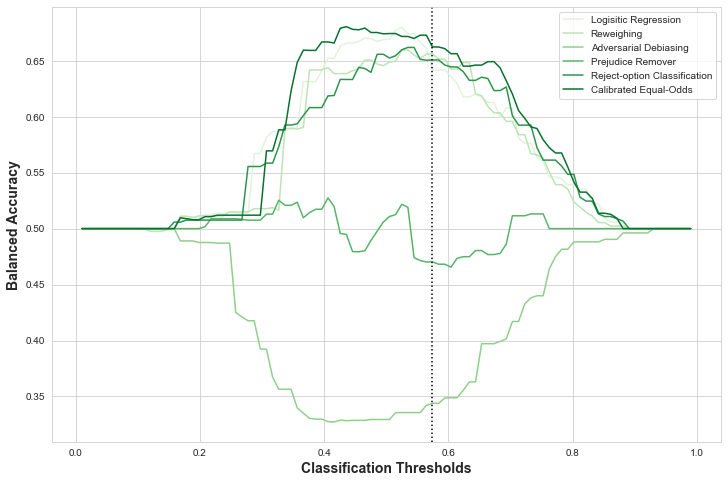

In [104]:
plot_results(filenames = ['LR_bal_acc_arr.json', 'RW_bal_acc_arr.json', 'AD_bal_acc_arr.json', 
    'PR_bal_acc_arr.json', 'ROC_bal_acc_arr.json', 'CEOD_bal_acc_arr.json'],
    metricname = 'Balanced Accuracy', saveto = 'RES_balanced_accuracy.png')

In [ ]:
plot_results(filenames = ['LR_bal_acc_arr.json', 'RW_bal_acc_arr.json', 'AD_bal_acc_arr.json', 
    'PR_bal_acc_arr.json', 'ROC_bal_acc_arr.json', 'CEOD_bal_acc_arr.json'],
    metricname = 'Balanced Accuracy', saveto = 'RES_balanced_accuracy.png')

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


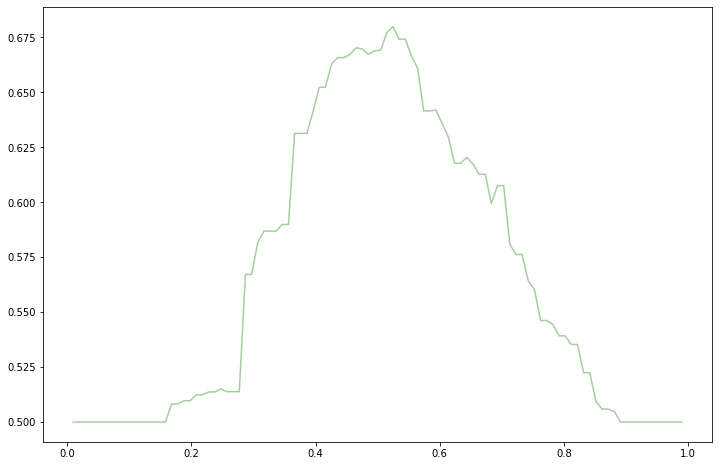

In [79]:
plt.figure(figsize = (12, 8))
ax = sns.lineplot(class_thresh_arr, bal_acc_arr, color = '#a4ce9e')